# Importing section

In [16]:
import urllib.request
import re
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pyspark.sql import SparkSession
from datetime import datetime

In [8]:
warnings.filterwarnings("ignore")

# Getting log and initialize spark

In [9]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

spark = SparkSession.builder.getOrCreate()
spark
sc = spark.sparkContext

24/10/10 13:27:05 WARN Utils: Your hostname, MacBook-Pro-BartomiejK.local resolves to a loopback address: 127.0.0.1; using 192.168.33.5 instead (on interface en0)
24/10/10 13:27:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/10 13:27:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/10 13:27:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Zadanie nr 1

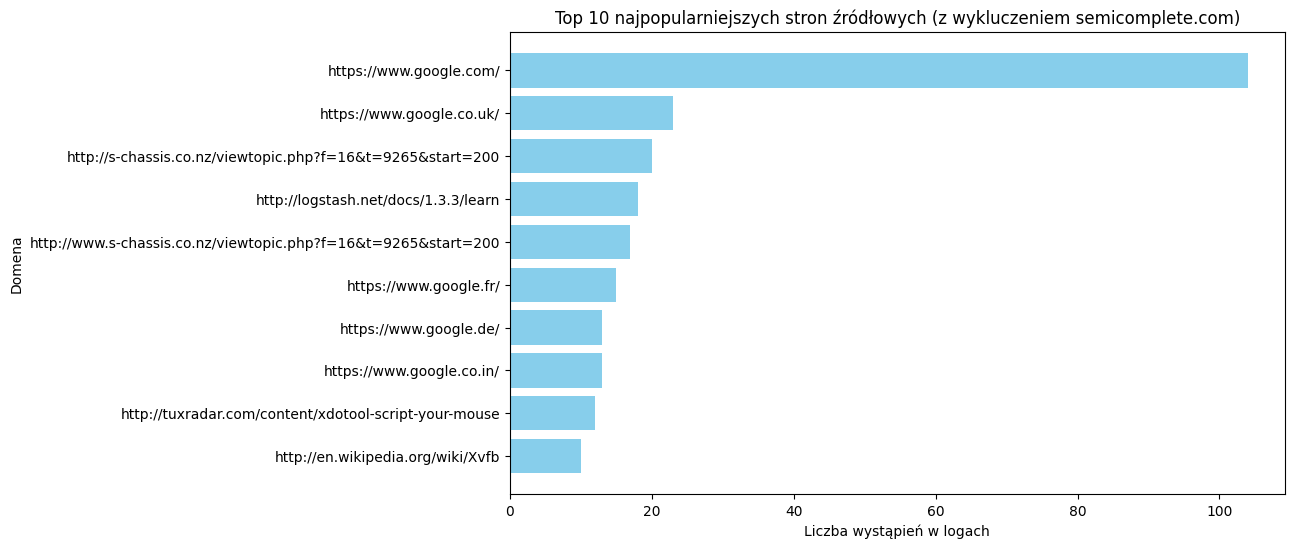

In [13]:
RDD_logs = sc.textFile("apache_logs")

def parse_log_line(line):
    try:
        parts = line.split(' ')
        referer = parts[10].strip('"')
        if referer != "-" and "semicomplete.com" not in referer:
            return referer
    except Exception as e:
        pass
    return None

def plot(rf_df):
    plt.figure(figsize=(10, 6))
    plt.barh(rf_df['referer'], rf_df['count'], color='skyblue')
    plt.xlabel('Liczba wystąpień w logach')
    plt.ylabel('Domena')
    plt.title('Top 10 najpopularniejszych stron źródłowych (z wykluczeniem semicomplete.com)')
    plt.gca().invert_yaxis()
    plt.show()

referers_rdd = RDD_logs.map(parse_log_line).filter(lambda x: x is not None)
referer_counts = referers_rdd.map(lambda referer: (referer, 1)).reduceByKey(lambda a, b: a + b)

referer_df = referer_counts.toDF(["referer", "count"])
referer_df_pandas = referer_df.toPandas()

# zmienić head w razie potrzeby
referer_df_pandas_sorted = referer_df_pandas.sort_values(by = "count", ascending = False).head(10)

plot(referer_df_pandas_sorted)

# Zadanie nr 2

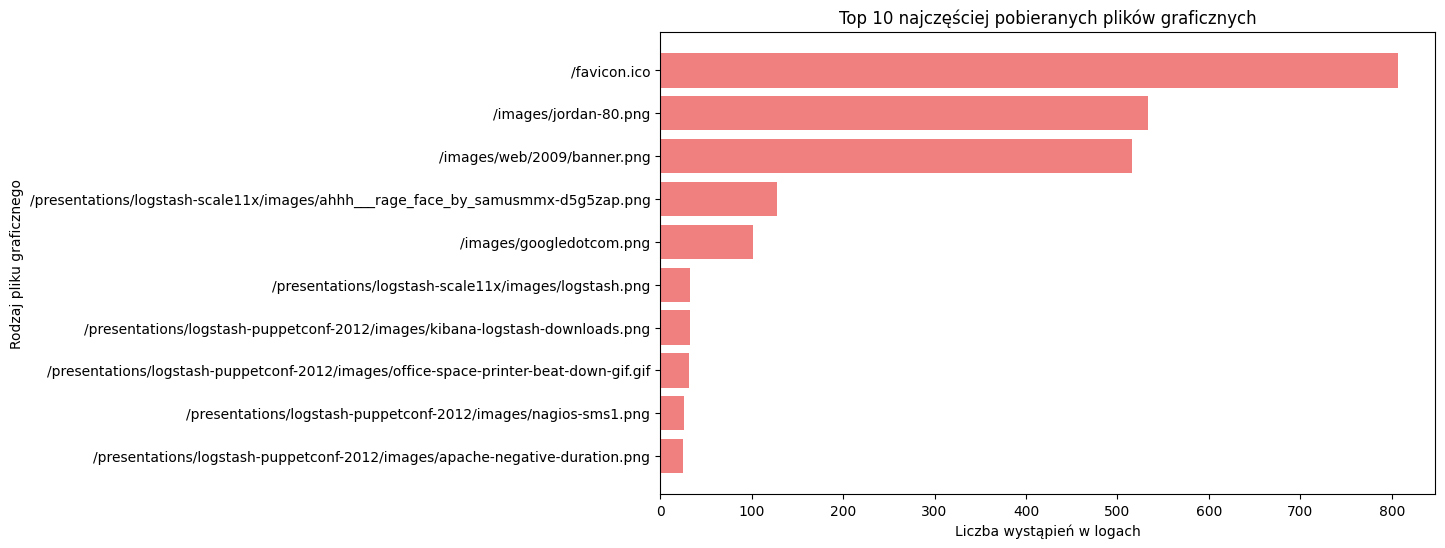

In [15]:
def parse_log_line_for_images(line):
    try:
        parts = line.split(' ')
        request = parts[6]
        if any(ext in request for ext in ['.jpg', '.png', '.gif', '.ico']):
            return request
    except Exception as e:
        pass
    return None

def plot_img(imdf):
    plt.figure(figsize=(10, 6))
    plt.barh(imdf['image'], imdf['count'], color='lightcoral')
    plt.xlabel('Liczba wystąpień w logach')
    plt.ylabel('Rodzaj pliku graficznego')
    plt.title('Top 10 najczęściej pobieranych plików graficznych')
    plt.gca().invert_yaxis()
    plt.show()

images_rdd = RDD_logs.map(parse_log_line_for_images).filter(lambda x: x is not None)
image_counts = images_rdd.map(lambda image: (image, 1)).reduceByKey(lambda a, b: a + b)

image_df = image_counts.toDF(["image", "count"])
image_df_pandas = image_df.toPandas()

# zmienić head w razie potrzeby, analogicznie jak w przypadku referer_df_pandas_sorted
image_df_pandas_sorted = image_df_pandas.sort_values(by = "count", ascending = False).head(10)

def plot_img(imdf):
    plt.figure(figsize=(10, 6))
    plt.barh(imdf['image'], imdf['count'], color='lightcoral')
    plt.xlabel('Liczba wystąpień w logach')
    plt.ylabel('Pobrany plik graficzny')
    plt.title('Top 10 najczęściej pobieranych plików graficznych')
    plt.gca().invert_yaxis()
    plt.show()

plot_img(image_df_pandas_sorted)


# Zadanie nr 3

In [ ]:
def parse_log_line_for_time(line):
    try:
        parts = line.split(' ')
        timestamp = parts[3].strip('[')
        dt = datetime.strptime(timestamp, "%d/%b/%Y:%H:%M:%S")
        # zwracamy czas w minutach, żeby łatwiej było grupować, można też zwrócić pełną datę
        return dt.hour * 60 + dt.minute
    except Exception as e:
        return None
    
def plot_time(tdf):
    plt.figure(figsize=(12, 6))
    plt.plot(tdf['time'], tdf['count'], color = 'blue', linewidth = 1.5)
    plt.xticks(rotation = 90)
    plt.xlabel('Czas (HH:MM)')
    plt.ylabel('Liczba wywołań tzw. requestów')
    plt.title('Średnia liczba wywołań na minutę w ciągu doby')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

times_rdd = RDD_logs.map(parse_log_line_for_time).filter(lambda x: x is not None)
time_counts = times_rdd.map(lambda minute: (minute, 1)).reduceByKey(lambda a, b: a + b)

time_df = time_counts.toDF(["minute_of_day", "count"])
time_df_pandas = time_df.toPandas()

time_df_pandas['time'] = time_df_pandas['minute_of_day'].apply(lambda x: f"{x//60:02d}:{x%60:02d}")
time_df_pandas_sorted = time_df_pandas.sort_values(by = "minute_of_day")

plot_time(time_df_pandas_sorted)